# Importar librerías y cargar la imagen
En esta celda se importan las librerías necesarias (OpenCV y Matplotlib) y se carga la imagen en color desde la carpeta `IMG`. Luego se convierte a escala de grises para simplificar el procesamiento posterior.

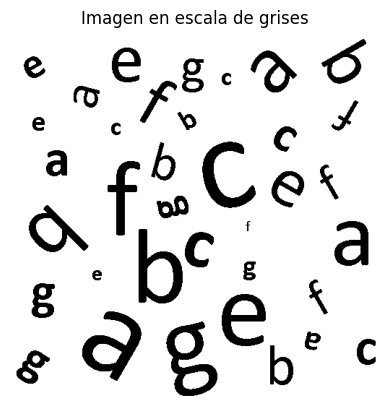

In [1]:
# Importar librerías para procesamiento y visualización de imágenes
import cv2  # OpenCV: carga y operaciones sobre imágenes
import matplotlib.pyplot as plt  # Para mostrar imágenes y gráficos

# Cargar la imagen en color (BGR en OpenCV)
img = cv2.imread('sopa_letras.png')  # ruta relativa a la carpeta del notebook

# Convertir la imagen a escala de grises para simplificar el análisis
# Esto reduce la dimensionalidad y facilita operaciones como umbralizado
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Mostrar la imagen en escala de grises usando matplotlib
plt.figure()
plt.imshow(gray, cmap='gray')  # cmap='gray' para visualizar en escala de grises
plt.title('Imagen en escala de grises')
plt.axis('off')  # ocultar ejes para una visualización limpia
plt.show()

# Binarizar la imagen
Se aplica un umbral binario inverso para separar las letras (objetos) del fondo. Esto facilita la detección y etiquetado de regiones en las siguientes celdas.

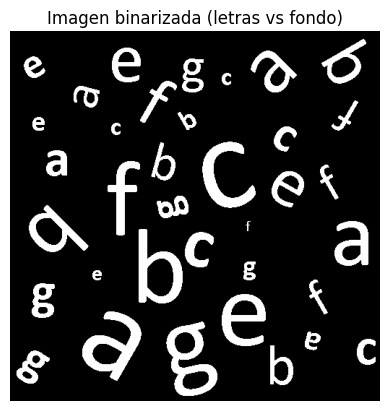

In [2]:
# Aplicar umbral binario inverso para separar letras del fondo
# cv2.threshold devuelve (retorno, imagen_umbralizada). THRESH_BINARY_INV invierte la máscara
ret, bw = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

# Mostrar la imagen binarizada. Las letras deberían aparecer en blanco (foreground).
plt.figure()
plt.imshow(bw, cmap='gray')
plt.title('Imagen binarizada (letras vs fondo)')
plt.axis('off')
plt.show()

# Etiquetado y extracción de propiedades
Se etiquetan los objetos en la imagen binaria y se extraen propiedades de cada región con `skimage.measure.regionprops`. También se visualizan ejemplos de etiquetas específicas.

Número de regiones detectadas: 36


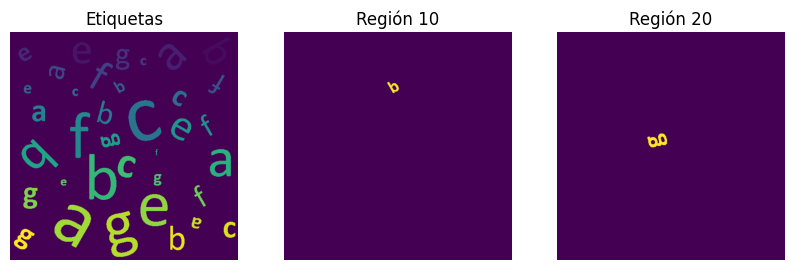

In [3]:
# Importar funciones para etiquetado y análisis de regiones
from skimage.measure import label, regionprops  # label: etiquetar, regionprops: extraer propiedades
import numpy as np

# Etiquetar cada objeto en la imagen binaria (cada objeto recibe un entero distinto)
eq = label(bw)

# Extraer propiedades de las regiones etiquetadas (lista de objetos con atributos)
sts = regionprops(label_image=eq)

# Convertir la matriz de etiquetas a un array de NumPy para facilitar su manipulación
eq = np.array(eq)

# Imprimir el número de regiones detectadas (valor máximo de etiqueta)
print('Número de regiones detectadas:', np.max(eq))

# Visualizar etiquetas y algunos ejemplos concretos (etiqueta 10 y 20) para inspección
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(10)
ax[0].imshow(eq)  # mapa de etiquetas (cada etiqueta es un entero)
ax[0].set_title('Etiquetas')
ax[1].imshow(eq == 10)  # máscara booleana para la etiqueta 10
ax[1].set_title('Región 10')
ax[2].imshow(eq == 20)  # máscara booleana para la etiqueta 20
ax[2].set_title('Región 20')
for a in ax:
    a.axis('off')
plt.show()

# Momentos y características invariantes
Se definen funciones para calcular momentos espaciales, momentos centrales y momentos normalizados (invariantes a escala) y se usan para calcular 4 características Fhi de cada región.

In [4]:
# Función Momento: calcula el momento espacial M_{r,s} sobre la máscara (pixels != 0)
def Momento (r, s, img):
    # R contiene las coordenadas (fila, columna) de los píxeles de primer plano
    R = np.argwhere(img != 0)

    i = R[:,0].astype(float)  # coordenadas de fila (y)
    j = R[:,1].astype(float)  # coordenadas de columna (x)

    # suma de i^r * j^s sobre todos los píxeles de la región
    return np.sum((i**r) * (j**s))

# Momento central: momento calculado respecto al centroide (invarianza a traslación)
def Momento_central(r, s, img):
    R = np.argwhere(img != 0)

    i = R[:,0].astype(float)
    j = R[:,1].astype(float)
    m00 = Momento(0,0,img)  # masa total (número de píxeles de la región)

    # centroide (i0, j0)
    i0 = Momento(1,0,img)/ m00
    j0 = Momento(0,1,img)/ m00

    # suma de (i - i0)^r * (j - j0)^s
    return np.sum((i - i0)**r * (j - j0)**s)

# Momento normalizado (invariante a escala) usado para formar descriptores
def Momento_Hu (r, s, img):
    # t = (r+s)/2 + 1 es el exponente de normalización común para momentos centrales
    t = (r + s)/2.0 + 1.0
    mu00 = Momento_central(0,0,img)  # momento central de orden 0 (masa)
    # normalizar para obtener invariancia frente a escala
    return Momento_central(r, s, img) / (mu00**t)

# compute_Fhis: construye un conjunto compacto de 4 características basadas en momentos normalizados
def compute_Fhis(mask):
    # calcular momentos normalizados necesarios
    n20 = Momento_Hu(2,0,mask)
    n02 = Momento_Hu(0,2,mask)
    n11 = Momento_Hu(1,1,mask)
    n30 = Momento_Hu(3,0,mask)
    n12 = Momento_Hu(1,2,mask)
    n21 = Momento_Hu(2,1,mask)
    n03 = Momento_Hu(0,3,mask)

    # ensamblar características F1..F4 (ejemplos de combinaciones invariantes)
    F1 = n20 + n02
    F2 = (n20 - n02)**2 + 4*(n11**2)
    F3 = (n30 - 3*n12)**2 + (3*n21 - n03)**2
    F4 = (n30 + n12)**2 + (n21 + n03)**2

    return [F1, F2, F3, F4]

# Aplicar compute_Fhis a cada región (sts es la lista de regionprops)
Fhis = [compute_Fhis(s.image) for s in sts]
# Separar cada componente para análisis posterior
Fhi1 = [f[0] for f in Fhis]
Fhi2 = [f[1] for f in Fhis]
Fhi3 = [f[2] for f in Fhis]
Fhi4 = [f[3] for f in Fhis]

# Perímetros de las regiones
Se calcula el perímetro de cada región usando contornos de OpenCV y se devuelve la lista de perímetros correspondiente a cada etiqueta.

In [5]:
# compute_perimeters: calcula el perímetro (longitud de contorno) para cada etiqueta en 'eq'
def compute_perimeters(eq):
    perimeters = []
    max_label = int(np.max(eq))  # número máximo de etiqueta
    # iterar por cada etiqueta (asumiendo etiquetas en 1..max_label)
    for lab in range(1, max_label + 1):
        # crear máscara binaria de la región actual
        mask = (eq == lab).astype(np.uint8)  
        # encontrar contornos en la máscara. findContours devuelve diferentes tuplas según la versión de OpenCV
        res = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours = res[0] if len(res) == 2 else res[1]
        # sumar la longitud de todos los contornos (en caso de múltiples contornos por etiqueta)
        perim = sum(float(cv2.arcLength(cnt, True)) for cnt in contours)
        perimeters.append(perim)
    return perimeters

# Ejecutar la función para obtener perímetros de todas las regiones etiquetadas
perimeters = compute_perimeters(eq) 

# Redondez y orientación
Se calculan el área y el perímetro de cada región para obtener una medida de redondez (circularidad). También se calcula la orientación de la elipse que ajusta cada región.

In [6]:
# Calcular áreas a partir de las propiedades de las regiones
areas = [s.area for s in sts]

# compute_redondez: medida de circularidad (4*pi*area / perimetro^2). 1.0 => círculo perfecto
def compute_redondez(areas, perimeters):
    d = [4 * np.pi * a / (p**2) if p != 0 else 0 for a, p in zip(areas, perimeters)]
    return d

# aplicar la función anterior para obtener la redondez por región
redondez = compute_redondez(areas, perimeters)

# orientación: convertir de radianes a grados para interpretación humana
orientaciones = [np.degrees(s.orientation) for s in sts]

# Crear un DataFrame con características
Se recopilan las características calculadas (momentos, perímetro, redondez y orientación) en un `DataFrame` de pandas para su análisis o exportación.

In [7]:
# Crear un DataFrame con las características extraídas para cada región
import pandas as pd

rows = []
for i, s in enumerate(sts):
    # máscara binaria para la región i+1 (las etiquetas empiezan en 1)
    mask = (eq == (i + 1)).astype(np.uint8)
    # calcular las 4 características basadas en momentos para la máscara
    Fhi1, Fhi2, Fhi3, Fhi4 = compute_Fhis(mask)
    rows.append({
        'Fhi1': Fhi1,
        'Fhi2': Fhi2,
        'Fhi3': Fhi3,
        'Fhi4': Fhi4,
        'Perimetro': perimeters[i],  # perímetro calculado previamente
        'Redondez': redondez[i],  # circularidad
        'Orientacion': np.rad2deg(s.orientation)  # orientación en grados
    })

# construir DataFrame con columnas en orden definido
df = pd.DataFrame(rows, columns=['Fhi1','Fhi2','Fhi3','Fhi4','Perimetro','Redondez','Orientacion'])

print(df)

        Fhi1      Fhi2      Fhi3      Fhi4   Perimetro  Redondez  Orientacion
0   0.425378  0.025908  0.013871  0.000732  226.350286  0.297270   -40.872019
1   0.337127  0.003917  0.000911  0.000407  206.710677  0.285858    -9.885364
2   0.363250  0.011855  0.002181  0.000449  251.705625  0.260627    38.498525
3   0.257982  0.001658  0.000276  0.000161  129.195958  0.351584    21.608321
4   0.364220  0.032158  0.001117  0.000161  188.710677  0.261831    -3.364221
5   0.292098  0.010319  0.002518  0.000852   67.112698  0.365487     0.000000
6   0.533992  0.213339  0.025221  0.008095  215.178713  0.203008   -36.881241
7   0.354090  0.010660  0.002156  0.000553  150.325901  0.270814    66.108341
8   0.535181  0.213728  0.025933  0.008523  153.580734  0.204049   -36.903398
9   0.292864  0.012324  0.004910  0.000336   88.911687  0.449861    50.370361
10  0.230027  0.000899  0.000148  0.000066   81.455844  0.409090    -9.694305
11  0.292098  0.010319  0.002518  0.000852   67.112698  0.365487

# Visualizar centroides sobre la imagen
Se dibujan los centros de masa (centroides) calculados para cada región sobre la imagen en color original para verificar su localización.

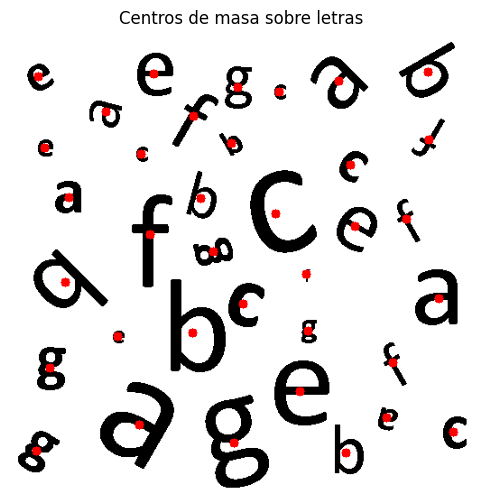

In [8]:
# Dibujar centroides sobre la imagen original para ver la localización de cada región
img_centroides = img.copy()
for s in sts:
    cy, cx = s.centroid  # regionprops devuelve centroid en formato (fila, columna)
    # dibujar un círculo relleno pequeño en cada centroide (BGR)
    cv2.circle(img_centroides, (int(cx), int(cy)), 5, (0, 0, 255), -1) 

# mostrar la imagen convertida a RGB para matplotlib
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_centroides, cv2.COLOR_BGR2RGB))
plt.title("Centros de masa sobre letras")
plt.axis("off")
plt.show()